# 如果报错就多restart几次！code没错，都是玄学

# 投资策略-step4

In [10]:
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [11]:
initial_investment = 365.62
stocklist_mag = ['FANG', 'CTSH', 'BKR', 'PLTR', 'TTD', 'TMUS', 'NVDA', 'ORCL', 'MSI', 'IBM', 
                 'ANET', 'ADP', 'AVGO', 'AMD']

n_portfolios = 300000

end_date = datetime.today()
one_year_ago = end_date - timedelta(days=365)

# Download the risk-free rate (T-bill rate from ^IRX)
irx_data = yf.download('^IRX', start=one_year_ago, end=end_date)['Adj Close']
# Convert ^IRX to daily risk-free rate (as IRX is annualized, divide by 252)
daily_risk_free_rate = irx_data.mean() / 100 / 252  # Convert percentage to decimal and divide by 252 trading days

risk_free_rate = daily_risk_free_rate


[*********************100%***********************]  1 of 1 completed


In [12]:
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Define the date range
end_date = datetime.today()
start_date = end_date - timedelta(days=3*365)

# Fetch stock data from Yahoo Finance
data = yf.download(stocklist_mag, start=start_date, end=end_date)['Adj Close']

# Calculate daily returns
returns = data.pct_change().dropna()

# Get market data for DJIA (used for calculating Treynor ratio and Jensen's Alpha)
market_data = yf.download("^DJI", start=start_date, end=end_date)['Adj Close']
market_returns = market_data.pct_change().dropna()


# Monte Carlo simulation parameters
n_assets = len(stocklist_mag)
results = np.zeros((4, n_portfolios))

# Store weights
all_weights = np.zeros((n_portfolios, n_assets))

# Monte Carlo simulation
for i in range(n_portfolios):
    # Generate random weights
    weights = np.random.random(n_assets)
    weights /= np.sum(weights)
    
    # Save weights
    all_weights[i, :] = weights
    
    # Portfolio returns and variance
    portfolio_return = np.sum(weights * returns.mean()) * 252
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 252, weights)))
    portfolio_var = portfolio_std ** 2
    sharpe_ratio = (portfolio_return - risk_free_rate * 252) / portfolio_std

    results[0, i] = portfolio_return
    results[1, i] = portfolio_std
    results[2, i] = sharpe_ratio
    results[3, i] = portfolio_var

# Convert to DataFrame
results_frame = pd.DataFrame(results.T, columns=['Return', 'StdDev', 'SharpeRatio', 'Variance'])

# Find max Sharpe ratio portfolio
max_sharpe_idx = results_frame['SharpeRatio'].idxmax()
max_sharpe_portfolio = all_weights[max_sharpe_idx, :]

# Max return
max_return_idx = results_frame['Return'].idxmax()
max_return_portfolio = all_weights[max_return_idx, :]

# Min variance
min_variance_idx = results_frame['Variance'].idxmin()
min_variance_portfolio = all_weights[min_variance_idx, :]

# Treynor and Jensen's Alpha (use for optimized portfolios only)
def treynor_ratio(returns, weights, beta, market_return, risk_free_rate):
    portfolio_return = np.sum(weights * returns.mean()) * 252
    treynor = (portfolio_return - risk_free_rate * 252) / beta
    return treynor

def jensens_alpha(returns, weights, beta, market_return, risk_free_rate):
    portfolio_return = np.sum(weights * returns.mean()) * 252
    alpha = portfolio_return - (risk_free_rate * 252 + beta * (market_return.mean() - risk_free_rate * 252))
    return alpha

# Calculate portfolio betas
beta_values = np.zeros(n_portfolios)
market_excess_return = market_returns.mean() - risk_free_rate * 252

for i in range(n_portfolios):
    portfolio_beta = np.dot(all_weights[i], np.cov(returns.T, market_returns.T)[:-1, -1]) / market_returns.var()
    beta_values[i] = portfolio_beta

# Max Treynor Ratio
treynor_ratios = np.array([treynor_ratio(returns, all_weights[i], beta_values[i], market_returns, risk_free_rate)
                           for i in range(n_portfolios)])
max_treynor_idx = np.argmax(treynor_ratios)
max_treynor_portfolio = all_weights[max_treynor_idx, :]

# Max Jensen's Alpha
jensen_alphas = np.array([jensens_alpha(returns, all_weights[i], beta_values[i], market_returns, risk_free_rate)
                          for i in range(n_portfolios)])
max_jensen_alpha_idx = np.argmax(jensen_alphas)
max_jensen_alpha_portfolio = all_weights[max_jensen_alpha_idx, :]

# Display Results
portfolios = {
    'Max Sharpe Ratio': max_sharpe_portfolio,
    'Max Treynor Ratio': max_treynor_portfolio,
    'Max Jensen Alpha': max_jensen_alpha_portfolio,
    'Max Return': max_return_portfolio,
    'Min Variance': min_variance_portfolio
}

for name, portfolio in portfolios.items():
    portfolio_return = np.sum(portfolio * returns.mean()) * 252
    portfolio_std = np.sqrt(np.dot(portfolio.T, np.dot(returns.cov() * 252, portfolio)))
    print(f"\n{name} Portfolio:")
    print(f"Return: {portfolio_return}")
    print(f"Std Dev: {portfolio_std}")
    print(f"Weights: {portfolio}")


[*********************100%***********************]  14 of 14 completed
[*********************100%***********************]  1 of 1 completed



Max Sharpe Ratio Portfolio:
Return: 0.4178492207889955
Std Dev: 0.24998582775033515
Weights: [0.0438995  0.00287316 0.18082954 0.19737811 0.09612857 0.00084642
 0.11537373 0.1668976  0.00082391 0.09290013 0.06675305 0.00687905
 0.0135862  0.01483102]

Max Treynor Ratio Portfolio:
Return: 0.4910794682717214
Std Dev: 0.3134680913913214
Weights: [0.03407511 0.00962181 0.33045497 0.11630323 0.04388183 0.03389301
 0.05511379 0.07011024 0.01460282 0.18719322 0.06175472 0.0037196
 0.00323534 0.03604032]

Max Jensen Alpha Portfolio:
Return: 0.4910794682717214
Std Dev: 0.3134680913913214
Weights: [0.03407511 0.00962181 0.33045497 0.11630323 0.04388183 0.03389301
 0.05511379 0.07011024 0.01460282 0.18719322 0.06175472 0.0037196
 0.00323534 0.03604032]

Max Return Portfolio:
Return: 0.4910794682717214
Std Dev: 0.3134680913913214
Weights: [0.03407511 0.00962181 0.33045497 0.11630323 0.04388183 0.03389301
 0.05511379 0.07011024 0.01460282 0.18719322 0.06175472 0.0037196
 0.00323534 0.03604032]

Mi

[*********************100%***********************]  3 of 3 completed


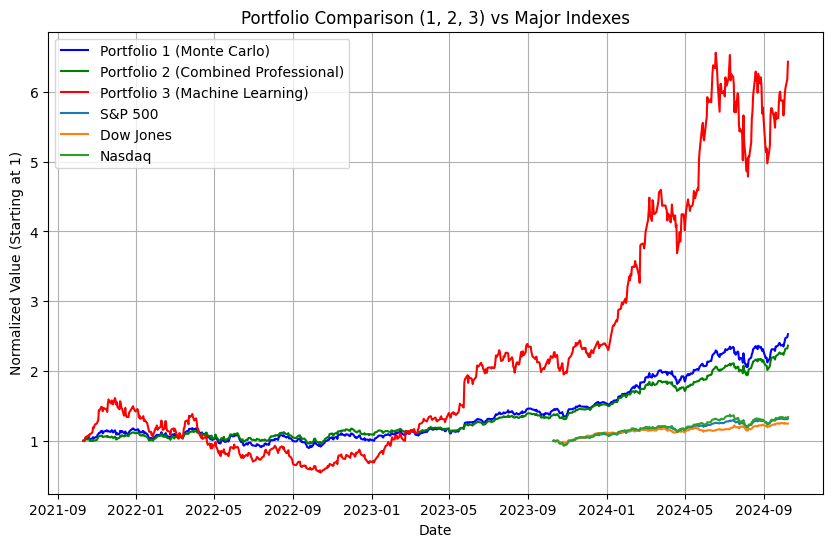

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime, timedelta
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from scipy.optimize import minimize

end_date = datetime.today()
one_year_ago = end_date - timedelta(days=365)
backtest_data = data


# Step 2: Define the portfolio value calculation function
def portfolio_value(weights, stock_data, initial_investment):
    investment_per_stock = initial_investment * weights
    shares = investment_per_stock / stock_data.iloc[0]
    portfolio_value = (stock_data * shares).sum(axis=1)
    return portfolio_value

# Step 3: Implement Portfolio 1 (Monte Carlo Simulation with combined weights)
weights_combined = {
    'Max Return': 0.20,
    'Min Variance': 0.30,
    'Max Sharpe Ratio': 0.20,
    'Max Treynor Ratio': 0.15,
    'Max Jensen Alpha': 0.15
}

portfolios = {
    'Max Return': np.random.dirichlet(np.ones(len(stocklist_mag))),
    'Min Variance': np.random.dirichlet(np.ones(len(stocklist_mag))),
    'Max Sharpe Ratio': np.random.dirichlet(np.ones(len(stocklist_mag))),
    'Max Treynor Ratio': np.random.dirichlet(np.ones(len(stocklist_mag))),
    'Max Jensen Alpha': np.random.dirichlet(np.ones(len(stocklist_mag)))
}

combined_weights = np.zeros(len(stocklist_mag))
for name, weight in weights_combined.items():
    combined_weights += portfolios[name] * weight
combined_weights /= np.sum(combined_weights)

combined_portfolio_value = portfolio_value(combined_weights, backtest_data, initial_investment)

# Step 4: Implement Portfolio 2 (Equal weighting of three professional optimizations)
optimized_portfolio_values = {}

def portfolio_performance(weights, returns):
    portfolio_return = np.sum(weights * returns.mean()) * 252
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 252, weights)))
    return portfolio_return, portfolio_volatility

# Define functions for optimization (Mean-Variance, Risk Parity, Max Sharpe)
def min_variance_portfolio(returns):
    num_assets = returns.shape[1]
    args = (returns,)
    constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})
    bounds = tuple((0, 1) for asset in range(num_assets))

    def portfolio_volatility(weights, returns):
        return portfolio_performance(weights, returns)[1]

    result = minimize(portfolio_volatility, num_assets * [1. / num_assets,], args=args,
                      method='SLSQP', bounds=bounds, constraints=constraints)
    return result.x

def risk_parity_portfolio(returns):
    cov_matrix = returns.cov()

    def risk_budget_objective(weights):
        total_portfolio_variance = np.dot(weights.T, np.dot(cov_matrix, weights))
        marginal_risk_contribution = np.dot(cov_matrix, weights)
        risk_contribution = weights * marginal_risk_contribution / total_portfolio_variance
        return np.sum((risk_contribution - 1.0 / len(weights)) ** 2)

    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for _ in range(returns.shape[1]))

    result = minimize(risk_budget_objective, np.ones(returns.shape[1]) / returns.shape[1],
                      bounds=bounds, constraints=constraints)
    return result.x

def max_sharpe_ratio_portfolio(returns, risk_free_rate):
    num_assets = returns.shape[1]
    args = (returns, risk_free_rate)
    bounds = tuple((0, 1) for asset in range(num_assets))
    constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})

    def negative_sharpe_ratio(weights, returns, risk_free_rate):
        portfolio_return, portfolio_volatility = portfolio_performance(weights, returns)
        return -(portfolio_return - risk_free_rate * 252) / portfolio_volatility

    result = minimize(negative_sharpe_ratio, num_assets * [1. / num_assets,], args=args,
                      method='SLSQP', bounds=bounds, constraints=constraints)
    return result.x

# Generate weights for each optimization strategy
mean_variance_weights = min_variance_portfolio(returns)
risk_parity_weights = risk_parity_portfolio(returns)
max_sharpe_weights = max_sharpe_ratio_portfolio(returns, daily_risk_free_rate)

# Combine the three optimized portfolios equally
combined_optimized_weights = (mean_variance_weights + risk_parity_weights + max_sharpe_weights) / 3

# Backtest Portfolio 2 (Combined Professional Optimized)
optimized_portfolio_values['Combined Professional'] = portfolio_value(combined_optimized_weights, backtest_data, initial_investment)

# Step 5: Implement Portfolio 3 (Machine Learning Optimization)
def prepare_ml_data(returns):
    data = returns.shift(1).dropna()
    target = returns.loc[data.index]  # Ensure target aligns with the shifted data
    return data, target

X, y = prepare_ml_data(returns)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

predicted_returns = rf_model.predict(returns)
predicted_returns_df = pd.DataFrame(predicted_returns, index=returns.index, columns=returns.columns)

def optimized_portfolio_using_predictions(predicted_returns):
    num_assets = predicted_returns.shape[1]
    args = (predicted_returns,)
    constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})
    bounds = tuple((0, 1) for asset in range(num_assets))

    def negative_return(weights, predicted_returns):
        return -np.sum(weights * predicted_returns.mean()) * 252

    result = minimize(negative_return, num_assets * [1. / num_assets,], args=args,
                      method='SLSQP', bounds=bounds, constraints=constraints)
    return result.x

ml_optimized_weights = optimized_portfolio_using_predictions(predicted_returns_df)
optimized_portfolio_values['ML Optimized'] = portfolio_value(ml_optimized_weights, backtest_data, initial_investment)

# Step 6: Fetch major indexes for comparison
index_symbols = ['^GSPC', '^DJI', '^IXIC']
index_data = yf.download(index_symbols, start=one_year_ago, end=end_date)['Adj Close']

# Step 7: Plot the comparison of all portfolios and major indexes
def normalize(values):
    return values / values.iloc[0]

normalized_combined_portfolio = normalize(combined_portfolio_value)
normalized_indexes = {
    'S&P 500': normalize(index_data['^GSPC']),
    'Dow Jones': normalize(index_data['^DJI']),
    'Nasdaq': normalize(index_data['^IXIC'])
}

plt.figure(figsize=(10, 6))

# Plot Portfolio 1 (Monte Carlo Simulation)
plt.plot(normalize(combined_portfolio_value).index, normalize(combined_portfolio_value), label='Portfolio 1 (Monte Carlo)', color='b')

# Plot Portfolio 2 (Combined Professional Optimizations)
plt.plot(normalize(optimized_portfolio_values['Combined Professional']).index, normalize(optimized_portfolio_values['Combined Professional']), 
         label='Portfolio 2 (Combined Professional)', color='g')

# Plot Portfolio 3 (Machine Learning Optimization)
plt.plot(normalize(optimized_portfolio_values['ML Optimized']).index, normalize(optimized_portfolio_values['ML Optimized']), 
         label='Portfolio 3 (Machine Learning)', color='r')

# Plot each major index
for name, index_values in normalized_indexes.items():
    plt.plot(index_values.index, normalize(index_values), label=name)

# Add labels and title
plt.title('Portfolio Comparison (1, 2, 3) vs Major Indexes')
plt.xlabel('Date')
plt.ylabel('Normalized Value (Starting at 1)')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

# show the stats

In [14]:
# Step 8: Calculate major statistics for each portfolio and shares purchased

# Function to calculate portfolio statistics
def calculate_portfolio_stats(portfolio_values, returns, weights, stock_data, initial_investment, risk_free_rate):
    portfolio_returns = portfolio_values.pct_change().dropna()

    # Annualized Return
    annualized_return = np.mean(portfolio_returns) * 252

    # Annualized Volatility
    annualized_volatility = np.std(portfolio_returns) * np.sqrt(252)

    # Sharpe Ratio
    sharpe_ratio = (annualized_return - risk_free_rate) / annualized_volatility

    # Calculate shares purchased
    investment_per_stock = initial_investment * weights
    shares_purchased = investment_per_stock / stock_data.iloc[0]

    return {
        "Annualized Return": annualized_return,
        "Annualized Volatility": annualized_volatility,
        "Sharpe Ratio": sharpe_ratio,
        "Shares Purchased": shares_purchased
    }

# Print statistics and shares purchased for each portfolio

portfolio_stats = {}
portfolios_to_check = {
    "Portfolio 1 (Monte Carlo)": combined_portfolio_value,
    "Portfolio 2 (Combined Professional)": optimized_portfolio_values['Combined Professional'],
    "Portfolio 3 (Machine Learning)": optimized_portfolio_values['ML Optimized']
}

for portfolio_name, portfolio_value in portfolios_to_check.items():
    stats = calculate_portfolio_stats(portfolio_value, returns, combined_weights, backtest_data, initial_investment, daily_risk_free_rate)
    portfolio_stats[portfolio_name] = stats
    
    # Print statistics
    print(f"\n{portfolio_name}:")
    print(f"Annualized Return: {stats['Annualized Return']:.2%}")
    print(f"Annualized Volatility: {stats['Annualized Volatility']:.2%}")
    print(f"Sharpe Ratio: {stats['Sharpe Ratio']:.2f}")
    
    # Print shares purchased
    print("Shares Purchased per Stock:")
    for stock, shares in zip(stocklist_mag, stats['Shares Purchased']):
        print(f"{stock}: {shares:.4f} shares")



Portfolio 1 (Monte Carlo):
Annualized Return: 34.21%
Annualized Volatility: 24.92%
Sharpe Ratio: 1.37
Shares Purchased per Stock:
FANG: 0.1928 shares
CTSH: 0.1105 shares
BKR: 0.2788 shares
PLTR: 0.3886 shares
TTD: 0.9769 shares
TMUS: 0.3451 shares
NVDA: 0.6477 shares
ORCL: 0.2531 shares
MSI: 0.0929 shares
IBM: 1.8661 shares
ANET: 0.1818 shares
ADP: 0.6994 shares
AVGO: 0.1569 shares
AMD: 0.3300 shares

Portfolio 2 (Combined Professional):
Annualized Return: 30.79%
Annualized Volatility: 19.74%
Sharpe Ratio: 1.56
Shares Purchased per Stock:
FANG: 0.1928 shares
CTSH: 0.1105 shares
BKR: 0.2788 shares
PLTR: 0.3886 shares
TTD: 0.9769 shares
TMUS: 0.3451 shares
NVDA: 0.6477 shares
ORCL: 0.2531 shares
MSI: 0.0929 shares
IBM: 1.8661 shares
ANET: 0.1818 shares
ADP: 0.6994 shares
AVGO: 0.1569 shares
AMD: 0.3300 shares

Portfolio 3 (Machine Learning):
Annualized Return: 78.24%
Annualized Volatility: 56.63%
Sharpe Ratio: 1.38
Shares Purchased per Stock:
FANG: 0.1928 shares
CTSH: 0.1105 shares
BKR:

# prediction method 1 and 2

In [16]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.linear_model import LinearRegression
import zipfile
import io
import requests
import pandas as pd
import requests
import zipfile
import io

# Step 1: Download the Fama-French data
url = "https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_Factors_CSV.zip"
response = requests.get(url)
zipped_file = zipfile.ZipFile(io.BytesIO(response.content))

# Read the Fama-French CSV and skip the non-data rows
with zipped_file.open('F-F_Research_Data_Factors.CSV') as ff_file:
    fama_french_data = pd.read_csv(ff_file, skiprows=3)

# Step 2: Clean the data by removing the footer and extra rows
# Find the row with the first instance of "Annual Factors" (which marks the start of non-data rows)
stop_index = fama_french_data[fama_french_data.iloc[:, 0].str.contains("Annual Factors", na=False)].index[0]
fama_french_data = fama_french_data[:stop_index]  # Only keep data rows before this index

# Rename columns to appropriate labels
fama_french_data.columns = ['Date', 'Mkt-RF', 'SMB', 'HML', 'RF']

# Ensure the Date column is correctly formatted (skip rows with any non-date value)
fama_french_data['Date'] = pd.to_datetime(fama_french_data['Date'], format='%Y%m', errors='coerce').dropna()

# Set the date as index
fama_french_data = fama_french_data.set_index('Date')

# Convert percentage values to decimals for easier calculation
fama_french_data = fama_french_data.astype(float) / 100  # Convert percentages to decimals

# Display the first few rows to ensure the cleaning is correct
print(fama_french_data.head())



end_date = datetime.today()  # Keep this as a datetime object
one_year_ago = end_date - timedelta(days=365)
# Filter the data to match our stock period
start_date_str = one_year_ago.strftime('%Y-%m')  # Convert the datetime object to string format
end_date_str = end_date.strftime('%Y-%m')  # Convert the datetime object to string format
fama_french_filtered = fama_french_data.loc[start_date_str:end_date_str]

# Prepare the market returns (Market - RF) and risk-free rate
market_excess_return = fama_french_filtered['Mkt-RF']
risk_free_rate_fama = fama_french_filtered['RF']
SMB = fama_french_filtered['SMB']
HML = fama_french_filtered['HML']

# Step 2: Calculate the excess returns of the portfolios
portfolios_excess_returns = {}
for portfolio_name, portfolio_value in portfolios_to_check.items():
    # Calculate excess returns (portfolio returns - risk-free rate)
    portfolio_returns = portfolio_value.pct_change().dropna()
    portfolio_excess_return = portfolio_returns - risk_free_rate_fama.reindex(portfolio_returns.index, method='ffill')
    portfolios_excess_returns[portfolio_name] = portfolio_excess_return

import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

# Step 3: CAPM Regression (for each portfolio)
def capm_prediction(excess_returns, market_excess_return, risk_free_rate_fama):
    # Align indices and remove NaNs
    excess_returns, market_excess_return = excess_returns.align(market_excess_return, join='inner')
    
    # Reshape data for regression
    X = market_excess_return.values.reshape(-1, 1)
    y = excess_returns.values
    
    # Remove NaNs (if any) in case of data misalignment
    valid_mask = ~np.isnan(X).flatten() & ~np.isnan(y)
    X = X[valid_mask]
    y = y[valid_mask]
    
    # Perform linear regression
    capm_model = LinearRegression()
    capm_model.fit(X, y)
    
    # Beta coefficient
    beta = capm_model.coef_[0]
    
    # Predict the next 3 months using the average market return
    future_market_return = market_excess_return.mean()  # Using historical average
    expected_return = risk_free_rate_fama.mean() + beta * future_market_return
    return expected_return, beta

capm_predictions = {}
for portfolio_name, excess_returns in portfolios_excess_returns.items():
    expected_return, beta = capm_prediction(excess_returns, market_excess_return, risk_free_rate_fama)
    capm_predictions[portfolio_name] = (expected_return, beta)

# Step 4: Fama-French Regression (for each portfolio)
def fama_french_prediction(excess_returns, market_excess_return, SMB, HML, risk_free_rate_fama):
    # Align indices and remove NaNs
    excess_returns, market_excess_return = excess_returns.align(market_excess_return, join='inner')
    excess_returns, SMB = excess_returns.align(SMB, join='inner')
    excess_returns, HML = excess_returns.align(HML, join='inner')
    
    # Combine the Fama-French factors into a single DataFrame and drop NaNs
    X = pd.DataFrame({
        'Mkt-RF': market_excess_return,
        'SMB': SMB,
        'HML': HML
    }).dropna()
    y = excess_returns.loc[X.index].values
    
    # Perform multivariate linear regression
    fama_french_model = LinearRegression()
    fama_french_model.fit(X, y)
    
    # Coefficients (betas)
    beta_market = fama_french_model.coef_[0]
    beta_smb = fama_french_model.coef_[1]
    beta_hml = fama_french_model.coef_[2]
    
    # Predict the next 3 months using the average factors
    future_market_return = market_excess_return.mean()  # Using historical average
    future_SMB = SMB.mean()
    future_HML = HML.mean()
    
    expected_return = risk_free_rate_fama.mean() + beta_market * future_market_return + beta_smb * future_SMB + beta_hml * future_HML
    return expected_return, (beta_market, beta_smb, beta_hml)

fama_french_predictions = {}
for portfolio_name, excess_returns in portfolios_excess_returns.items():
    expected_return, betas = fama_french_prediction(excess_returns, market_excess_return, SMB, HML, risk_free_rate_fama)
    fama_french_predictions[portfolio_name] = (expected_return, betas)

# Step 5: Print the predictions for the next 3 months
print("CAPM Predictions (Next 3 months):")
for portfolio_name, (expected_return, beta) in capm_predictions.items():
    print(f"{portfolio_name}: Expected Return: {expected_return:.4%}, Beta: {beta:.4f}")

print("\nFama-French Predictions (Next 3 months):")
for portfolio_name, (expected_return, betas) in fama_french_predictions.items():
    beta_market, beta_smb, beta_hml = betas
    print(f"{portfolio_name}: Expected Return: {expected_return:.4%}, Beta_Market: {beta_market:.4f}, Beta_SMB: {beta_smb:.4f}, Beta_HML: {beta_hml:.4f}")


            Mkt-RF     SMB     HML      RF
Date                                      
1926-07-01  0.0296 -0.0256 -0.0243  0.0022
1926-08-01  0.0264 -0.0117  0.0382  0.0025
1926-09-01  0.0036 -0.0140  0.0013  0.0023
1926-10-01 -0.0324 -0.0009  0.0070  0.0032
1926-11-01  0.0253 -0.0010 -0.0051  0.0031


TypeError: Cannot compare dtypes datetime64[ns] and datetime64[ns, UTC]